In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO     2017-05-08 12:32:00,327 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
import glob

In [4]:
files = glob.glob('/artemis/readout/2017-05-08_*_scan_lo_*.nc')
files.sort()

In [5]:
swas = []
for fn in files:
    ncf = NCFile(fn)
    swa = ncf.SweepArray0
    swas.append(swa)
    ncf.close()

<IPython.core.display.Javascript object>


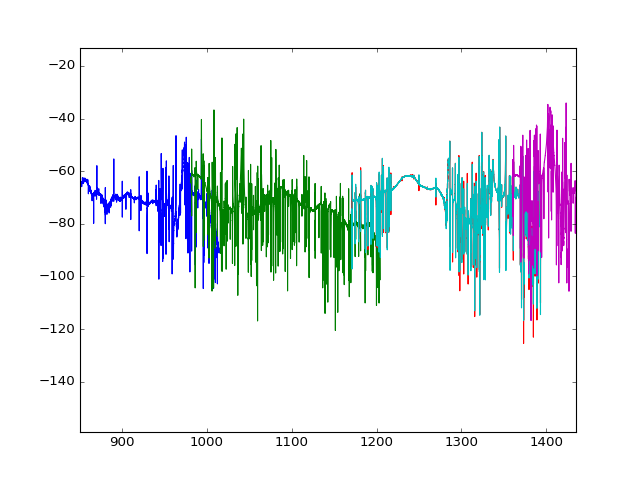

In [6]:
for swa in swas:
    plot(swa.frequency_MHz,dB(swa.s21_point))

In [7]:
from kid_readout.analysis.resonator import find_resonators

In [83]:
reload(find_resonators)

<module 'kid_readout.analysis.resonator.find_resonators' from '/home/gjones/kid_readout/kid_readout/analysis/resonator/find_resonators.py'>

In [97]:
freq = []
s21 = []
s21err = []
for swa in swas:
    freq.append(swa.frequency)
    s21.append(swa.s21_point)
    s21err.append(swa.s21_point_error)
freq = np.concatenate(freq)
s21 = np.concatenate(s21)
s21err = np.concatenate(s21err)

In [98]:
order = freq.argsort()
freq = freq[order]
s21 = s21[order]
s21err = s21err[order]
unique_mask = np.flatnonzero(np.diff(freq)!=0)
freq = freq[unique_mask]
s21 = s21[unique_mask]
s21err = s21err[unique_mask]


In [99]:
def find_candidates(freq,s21,spacing=1e6,threshold=1e-3):
    candidate_freqs = []
    candidate_indexes = []
    merit = np.abs(np.diff(np.abs(s21)))
    order = merit.argsort()
    for index in order[::-1]:
        if merit[index] < threshold:
            break
        if np.abs(freq[index]-10e6*round(freq[index]/10e6)) < 5e4:
            #print freq[index]
            continue
        if candidate_freqs:
            if (np.abs(np.array(candidate_freqs) - freq[index]).min() > spacing):
                #print "found candidate:",freq[index]
                candidate_freqs.append(freq[index])
                candidate_indexes.append(index)
        else:
            candidate_freqs = [freq[index]]
            candidate_indexes = [index]
    print "Found %d candidates" % len(candidate_freqs)
    return candidate_freqs,candidate_indexes

In [100]:
candidate_freqs,candidate_indexes = find_candidates(freq,s21,threshold=5e-5)

Found 371 candidates


<IPython.core.display.Javascript object>


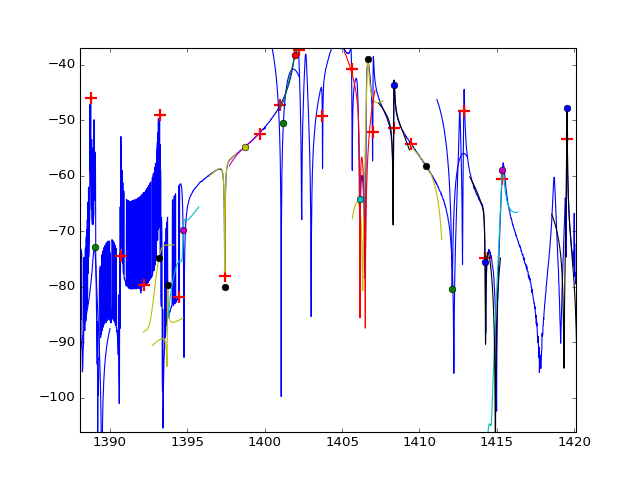

INFO     2017-05-08 14:22:10,348 - kid_readout.analysis.resonator.find_resonators.fit_candidates:36  Found possible resonator collision at 1034171684.8  1035140625.0
INFO     2017-05-08 14:22:16,356 - kid_readout.analysis.resonator.find_resonators.fit_candidates:36  Found possible resonator collision at 963409939.5  963372474.2
INFO     2017-05-08 14:22:24,791 - kid_readout.analysis.resonator.find_resonators.fit_candidates:36  Found possible resonator collision at 1545722884.5  1545140637.0
INFO     2017-05-08 14:23:05,191 - kid_readout.analysis.resonator.find_resonators.fit_candidates:36  Found possible resonator collision at 1527451643.1  1526912929.6
INFO     2017-05-08 14:24:27,902 - kid_readout.analysis.resonator.find_resonators.fit_candidates:36  Found possible resonator collision at 1307073072.9  1307227502.6
INFO     2017-05-08 14:25:21,099 - kid_readout.analysis.resonator.find_resonators.fit_candidates:36  Found possible resonator collision at 1091102534.6  1091062679.0
INFO  

In [101]:
figure()
resonators = find_resonators.fit_candidates(candidate_indexes,freq,s21,s21err,make_plot=True)

In [89]:
valid = [res for res in resonators if find_resonators.validate_resonator(res)]

1008160003.01 1406000000.0 failed low Qe
1406066731.48 1075262630.38 failed shallow
1423673553.57 1388917685.93 1436876876.44 1408350150.86 1043229233.63 failed high Qe
1034171023.07 1584646937.65 1403000000.0 1382125000.0 failed low Qe
1419531763.41 failed shallow
975109375.0 failed low Qe
963397088.879 failed high Qe
993391784.448 failed low Qe
1412884849.79 failed shallow
1017302335.84 1386522036.7 failed low Qe
1403171874.91 failed high range
981839456.749 1064098948.13 950984375.017 failed shallow
1545721964.61 995296875.0 failed low range
1547672825.08 1556829722.12 1345298260.26 1206314138.24 failed low Qe
1324178298.28 failed low Qe
977644197.906 failed shallow
1378844765.74 1582883856.25 failed shallow
1656233140.33 1035541757.79 1620500000.0 1369627054.18 failed low Q
1460189955.53 failed high Qe
1361667729.59 failed shallow
1084503555.93 1393189801.21 1345015811.0 failed low Q
1352431147.84 1450444499.77 1540043688.0 1321091474.61 failed high Qe
1075275726.24 failed low rang

<IPython.core.display.Javascript object>


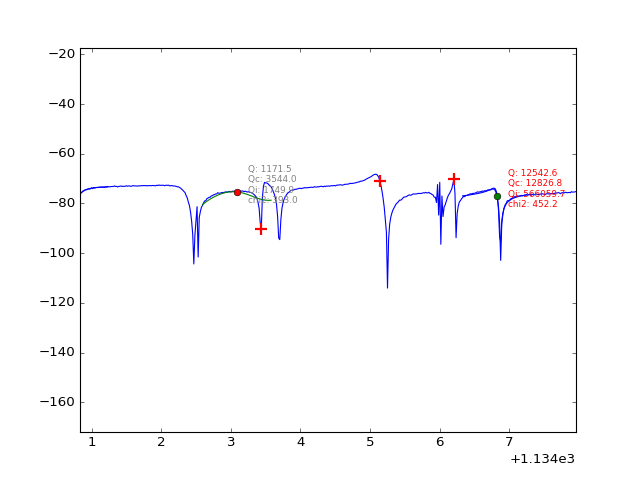

In [102]:
figure()
find_resonators.plot_results(freq,s21,valid,candidate_indexes,frequency_span=500e3)

In [146]:
in_range = [res for res in valid if np.abs(res.f_0-1250e6)<250e6]

In [147]:
len(in_range)

98

In [148]:
in_range_f0 = np.array([res.f_0 for res in in_range])

In [149]:
in_range_f0.sort()

In [174]:
full_list = [in_range_f0[0]]
num_dummies = 0
num_real = len(in_range_f0)
for f0 in in_range_f0[1:]:
    if num_dummies + num_real < 128:
        dummies = np.arange(full_list[-1],f0,2e6)
        if len(dummies) > 1:
            full_list.append(dummies[1])
            num_dummies += 1
    full_list.append(f0)
full_list = np.array(full_list)

In [175]:
full_list.shape

(128,)

<IPython.core.display.Javascript object>


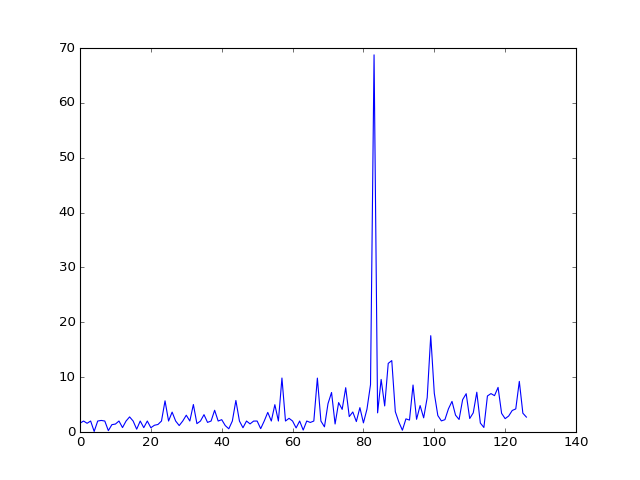

In [176]:
figure()
plot(np.diff(full_list)/1e6)

<IPython.core.display.Javascript object>


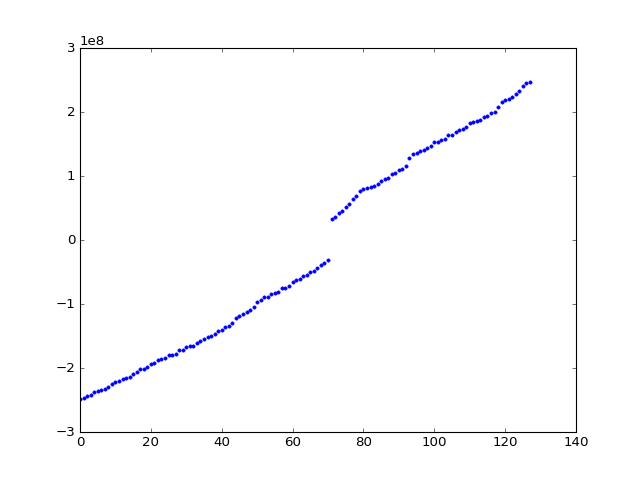

In [173]:
figure()
plot(full_list-1250e6,'.')

In [177]:
np.save('/artemis/readout/resonances/2017-05-08-bnl-hex-271-lo-1250-mhz-128.npy',full_list)

In [90]:
len(valid)

145

In [81]:
print len(candidate_freqs)

324


<IPython.core.display.Javascript object>


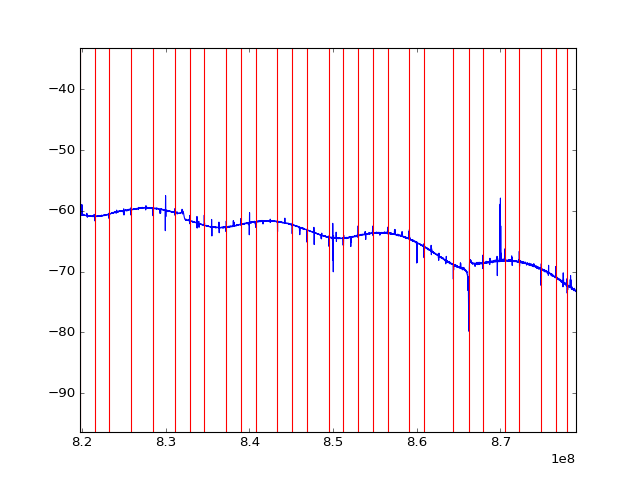

In [82]:
plot(freq,dB(s21))
for f in candidate_freqs:
    idx = np.abs(freq-f).argmin()
    axvline(freq[idx],dB(s21[idx]),color='r')

In [23]:
len(candidate_freqs)

43

<IPython.core.display.Javascript object>


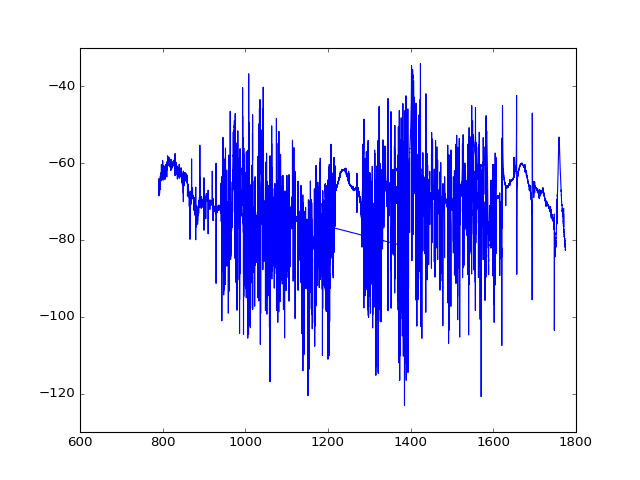

[]

In [20]:
find_resonators.find_resonators(freq,np.abs(s21),s21err,make_plot=True)